## Load data from DBPedia

In [1]:
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
labels = {
    0: "Company",
    1: "EducationalInstitution",
    2: "Artist",
    3: "Athlete",
    4: "OfficeHolder",
    5: "MeanOfTransportation",
    6: "Building",
    7: "NaturalPlace",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "WrittenWork"
}

K = len(labels)

In [3]:
df, _= datasets.load_dataset('dbpedia_14', split=['train', 'test'])
df: pd.DataFrame = df.to_pandas()
df = df[df.label.isin([3,7,9,12])].reset_index(drop=True)
data, _ = train_test_split(df, train_size=1000, stratify=df[['label']], random_state=910)

Reusing dataset d_bpedia14 (/Users/chenyongrui/.cache/huggingface/datasets/d_bpedia14/dbpedia_14/2.0.0/7f0577ea0f4397b6b89bfe5c5f2c6b1b420990a1fc5e8538c7ab4ec40e46fa3e)


In [4]:
data.reset_index(drop=True, inplace=True)

In [5]:
data

,label,title,content
0,7,Mount Xiqiao,Mount Xiqiao is a 40-50 million year old dorm...
1,9,Precious coral,Precious coral or red coral is the common nam...
2,3,Abram Elam,Abram Abe Elam (born October 15 1981) is an A...
3,12,Dreams That Money Can Buy,Dreams That Money Can Buy is a 1947 experimen...
4,7,Râul Iezerului,The Râul Iezerului is a tributary of the Râul...
...,...,...,...
995,7,Bramante (crater),Bramante is a crater on Mercury. It has a dia...
996,3,Matthew Wade,Matthew Scott Wade (born 26 December 1987) is...
997,9,Parnassius delphius,The Banded Apollo Parnassius delphius is a hi...
998,12,The Players (film),The Players (French: Les Infidèles) is a 2012...


## NLDA model
### Data Preparation

In [6]:
from settings.common import get_pp_pipeline, load_flat_dataset, save_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
from preprocessing_pipeline.NextGen import NextGen
from settings.common import load_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
import csv
import matplotlib.pyplot as plt

In [7]:
pp = get_pp_pipeline(remove_stopwords=True, stem=False, clean_twitter=False, lemmatize=True)

In [8]:
raw_data = pd.DataFrame(data.content)

In [9]:
raw_data.to_csv("dbpedia_raw.csv", header=False, index=False)

In [10]:
dataset = load_flat_dataset("dbpedia_raw.csv", delimiter=' ')

In [11]:
ng = NextGen()
clean_ds = ng._preprocess_dataset(dataset=dataset, pp=pp)
save_flat_dataset("dbpedia_clean.csv", clean_ds, delimiter=' ')

In [12]:
dataset = []
from src.gdtm.helpers.common import load_flat_dataset
from src.gdtm.models import GTM, NLDA

tnd_path = 'topic-noise-models-source/mallet-tnd/bin/mallet'
lda_path = 'topic-noise-models-source/mallet-lda/bin/mallet'
gtm_path = 'topic-noise-models-source/mallet-gtm/bin/mallet'
dataset = load_flat_dataset("dbpedia_clean.csv")

In [13]:
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [15]:
len(dataset)

2000

### Find the best k for NLDA model

In [37]:
coherence_list = []
for n in range(2, 6):
    model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=n, lda_k=n, tnd_beta1 = int(5*n/6), phi=int(n/3), top_words=30)
    coherence_list.append(model.get_coherent())

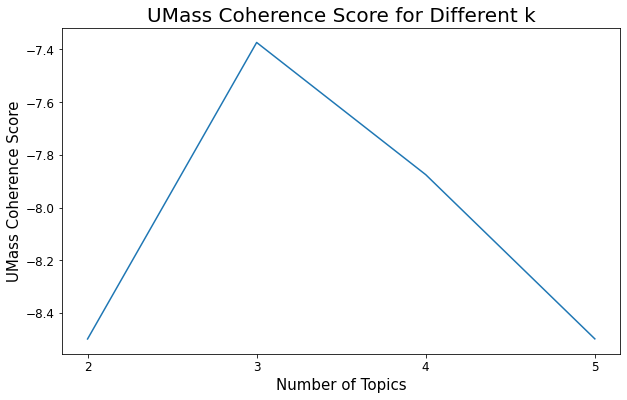

In [39]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 6),coherence_list)
plt.xlabel("Number of Topics", fontsize=15)
plt.ylabel("UMass Coherence Score", fontsize=15)
plt.xticks(range(2, 6, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("UMass Coherence Score for Different k", fontsize=20)
plt.savefig("Coherence_Score.png", dpi=300)

### Get the NLDA topics and noise

In [16]:
model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=20, lda_k=20, tnd_beta1=15, phi=12, top_words=30)

In [17]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('film', 656), ('river', 287), ('family', 192), ('directed', 178), ('born', 166), ('specie', 152), ('lake', 146), ('found', 115), ('film$directed', 113), ('football', 111), ('mountain', 100), ('american', 98), ('genus', 97), ('league', 94), ('south', 92), ('state', 79), ('moth', 79), ('starring', 76), ('played', 70), ('national', 69), ('play', 60), ('tributary', 59), ('produce', 58), ('sea', 58), ('player', 57), ('footballer', 56), ('north', 55), ('team', 54), ('part', 53), ('release', 52), ('professional', 51), ('county', 51), ('written', 50), ('drama', 48), ('world', 47), ('star', 47), ('high', 46), ('based', 46), ('season', 45), ('located', 44), ('united', 44), ('flow', 43), ('west', 43), ('western', 43), ('family$found', 43), ('romania', 42), ('drama$film', 41), ('international', 40), ('october', 39), ('park', 39), ('snail', 39), ('river$romania', 38), ('comedy', 38), ('year', 38), ('long', 38), ('august', 37), ('playing', 37), ('made', 37), ('italian', 36), ('club', 36), (

In [18]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [19]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [20]:
print(clean_topic)

[['range', 'peak', 'hill', 'level', 'metre', 'valley', 'germany', 'canada', 'elevation', 'summit', 'reach', 'province', 'point', 'san', 'foot', 'lower', 'big', 'china', 'border', 'main', 'mount', 'canton', 'pas', 'val', 'slope', 'district'], ['united$state', 'comedy$film', 'also$known', 'film$festival', 'film$written', 'film$star', 'film$based', 'film$produce', 'documentary$film', 'film$release', 'written$directed', 'horror$film', 'based$novel', 'international$film', 'produce$directed', 'novel$name', 'extinct$genus', 'lead$role', '1963', 'language$film', 'los$angeles', 'action$film', 'philippine', 'written$produce', 'north$america', 'film$shot', 'edward', 'take$place'], ['gastropod$mollusk', 'mollusk$family', 'indian', 'feature', 'marine$gastropod', 'india', 'snail$marine', 'specie$sea', '2004', 'national$park', 'studio', 'region$new', 'day', 'james', 'ridge', 'national$team', 'southwestern', 'specie$genus', 'bank', 'louis', 'south$island', 'located$west', 'land$snail', 'flow$generally

In [21]:
with open("dbpedia_NLDA_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

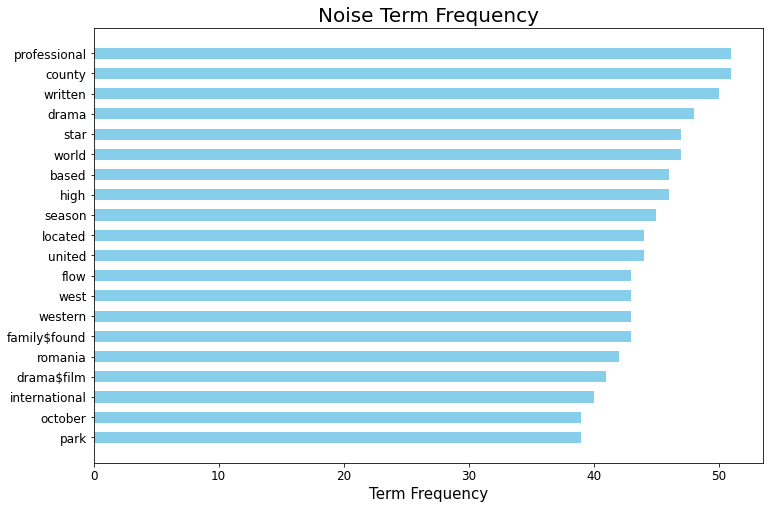

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[:20], noise_data.Noise_Weight[:20], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)